In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  4 13:33:48 2019

@author: mor
"""

import numpy as np
import pandas as pd
import psutil,os
import matplotlib.pyplot as plt
import dask
from dask import delayed



In [2]:


def memory_footprint():
    return psutil.Process(os.getpid()).memory_info().rss / 1024**2



In [3]:


celsius=np.random.uniform(-17.222,28.333,366000)    

# Print the size in MB of the celsius array
print(celsius.nbytes/1024**2)

# Call memory_footprint(): before
before=memory_footprint()

# Convert celsius by multiplying by 9/5 and adding 32: fahrenheit
fahrenheit = celsius*9/5+32

# Call memory_footprint(): after
after=memory_footprint()

# Print the difference between after and before
print(after - before)



2.7923583984375
2.79296875


In [4]:


# Create empty list: dfs
dfs = []

# Loop over 'WDI.csv'
for chunk in pd.read_csv('data/WDI.csv',chunksize=1000):
    # Create the first Series
    is_urban = chunk['Indicator Name']=='Urban population (% of total)'
    # Create the second Series
    is_AUS = chunk['Country Code']=='AUS'

    # Create the filtered chunk: filtered
    filtered=chunk.loc[is_urban & is_AUS]

    # Append the filtered chunk to the list dfs
    dfs.append(filtered)



92
36


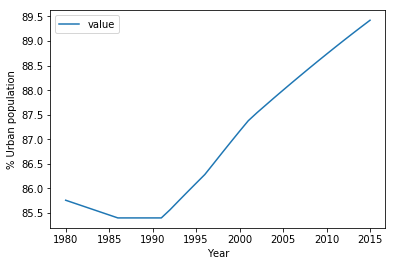

In [5]:



# Print length of list dfs
print(len(dfs))

# Apply pd.concat to dfs: df
df=pd.concat(dfs)

# Print length of DataFrame df
print(len(df))

# Call df.plot.line with x='Year' and y='value'
df.plot.line(x='Year', y='value')
plt.ylabel('% Urban population')

# Call plt.show()
plt.show()



In [6]:


# Define function with single input called df: pct_delayed
def pct_delayed(df):
    # Compute number of delayed flights: n_delayed
    n_delayed = (df['DEP_DELAY']>0).sum()
    # Return percentage of delayed flights
    return n_delayed  * 100 / len(df)



In [7]:

BASE=os.getcwd()
DATA=os.path.join(BASE,'data')
FLIGHTS=os.path.join(DATA,'flightdelays')

filenames=[os.path.join(FLIGHTS,filename) for filename in os.listdir(FLIGHTS)]


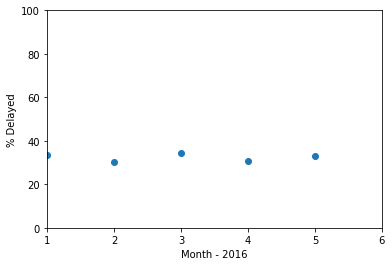

In [8]:
    
# Define the generator: dataframes
dataframes = (pd.read_csv(file) for file in filenames)

# Create the list comprehension: monthly_delayed
monthly_delayed = [pct_delayed(df) for df in dataframes]

# Create the plot
x = range(1,6)
plt.plot(x, monthly_delayed, marker='o', linewidth=0)
plt.ylabel('% Delayed')
plt.xlabel('Month - 2016')
plt.xlim((1,6))
plt.ylim((0,100))
plt.show()



In [9]:

import dask
from dask import delayed

@delayed
def read_one(filename):
    return pd.read_csv(filename)



In [10]:

# Define count_flights
@delayed
def count_flights(df):
    return len(df)

# Define count_delayed
@delayed
def count_delayed(df):
    return (df['DEP_DELAY']>0).sum()

# Define pct_delayed
@delayed
def pct_delayed(n_delayed,n_flights):
    return 100 * sum(n_delayed) / sum(n_flights)



32.406252934201824


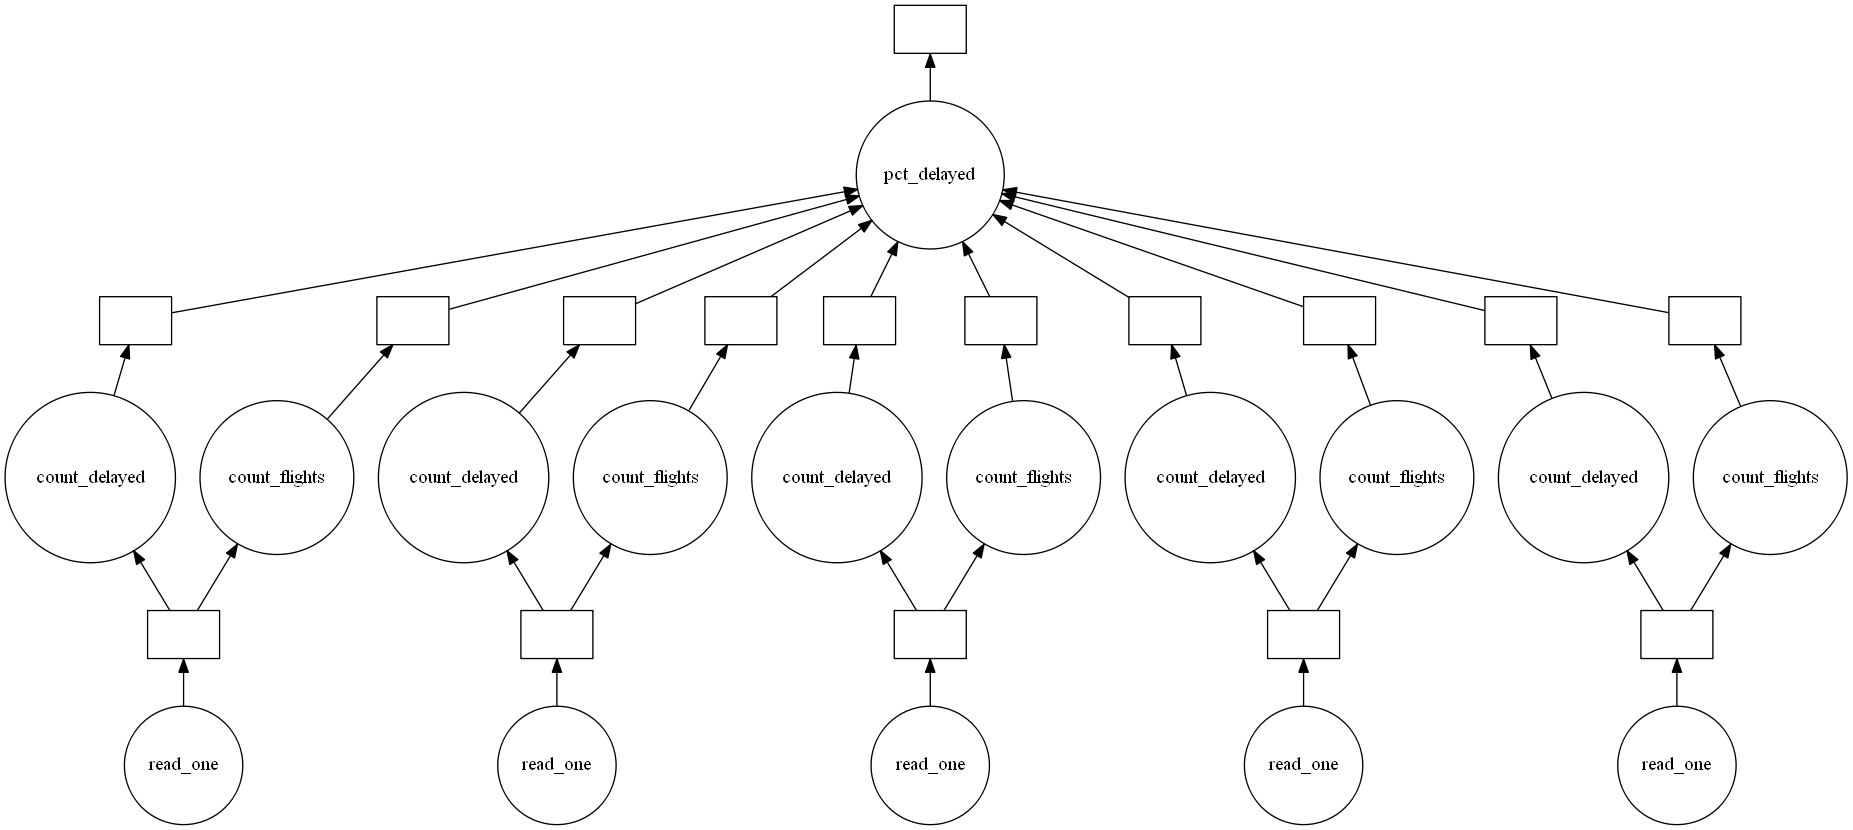

In [11]:

n_delayed=[]
n_flights=[]
# Loop over the provided filenames list and call read_one: df
for file in filenames:
    df = read_one(file)

    # Append to n_delayed and n_flights
    n_delayed.append(count_delayed(df))
    n_flights.append(count_flights(df))

# Call pct_delayed with n_delayed and n_flights: result
result = pct_delayed(n_delayed,n_flights)

# Print the output of result.compute()
print(result.compute())   


result.visualize()
    
    